<a href="https://colab.research.google.com/github/jellyXuuuuu/CovidNetDeepLearning/blob/main/3_recognize_lung%26gradcam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2 as cv
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

import tensorflow.compat.v1 as tf
import os, argparse
import cv2
import pandas as pd
from tqdm import tqdm
import json

# Load files

In [4]:
!cp -r 'drive/MyDrive/covid/models/' .

In [5]:
!cp -r 'drive/MyDrive/covid/labels/' .

In [6]:
!cp -r 'drive/MyDrive/covid/assets/' .

## Load other dataset

In [7]:
# covid-chestxray-dataset
!wget https://github.com/ieee8023/covid-chestxray-dataset/archive/refs/heads/master.zip

--2023-03-03 01:02:01--  https://github.com/ieee8023/covid-chestxray-dataset/archive/refs/heads/master.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/ieee8023/covid-chestxray-dataset/zip/refs/heads/master [following]
--2023-03-03 01:02:01--  https://codeload.github.com/ieee8023/covid-chestxray-dataset/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.112.9
Connecting to codeload.github.com (codeload.github.com)|140.82.112.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [  <=>               ] 525.03M  21.0MB/s    in 25s     

2023-03-03 01:02:26 (21.2 MB/s) - ‘master.zip’ saved [550535079]



In [8]:
!unzip master.zip

Archive:  master.zip
78543292f8b01d5e0ed1d0e15dce71949f0657bb
   creating: covid-chestxray-dataset-master/
   creating: covid-chestxray-dataset-master/.github/
 extracting: covid-chestxray-dataset-master/.github/FUNDING.yml  
   creating: covid-chestxray-dataset-master/.github/workflows/
  inflating: covid-chestxray-dataset-master/.github/workflows/tests.yml  
  inflating: covid-chestxray-dataset-master/.gitignore  
  inflating: covid-chestxray-dataset-master/README.md  
  inflating: covid-chestxray-dataset-master/SCHEMA.md  
   creating: covid-chestxray-dataset-master/annotations/
  inflating: covid-chestxray-dataset-master/annotations/covid-severity-scores.csv  
  inflating: covid-chestxray-dataset-master/annotations/imageannotation_ai_lung_bounding_boxes.json  
   creating: covid-chestxray-dataset-master/annotations/lungVAE-masks/
  inflating: covid-chestxray-dataset-master/annotations/lungVAE-masks/1-s2.0-S0140673620303706-fx1_lrg_mask.png  
  inflating: covid-chestxray-dataset-mas

# Show covid-model+gradcam plot graph
## for new final layer 
- update final layer name with 'conv5_block3_3_conv/BiasAdd:0'
- output tensor: dense_3/Softmax:0
- use code
[https://gist.github.com/nguyenhoa93/d49564875234f6722ff89e65db34a00b](https://https://gist.github.com/nguyenhoa93/d49564875234f6722ff89e65db34a00b)

In [2]:
"""
Generate GradCAM for COVID-Net model: https://github.com/lindawangg/COVID-Net
By: Hoa Nguyen
Last updated: May 23, 2020
"""
# Dependencies
import numpy as np
# import tensorflow as tf
import tensorflow.compat.v1 as tf
import os, argparse
import cv2
import pandas as pd
from tqdm import tqdm
import json
tf.disable_v2_behavior()

# parser = argparse.ArgumentParser(description='COVID-Net Inference')
# parser.add_argument('-model', default="COVID-Net-Small.json", help="Path to model specification")
# parser.add_argument('-impath', default='./data/test', help='Path to image')
# parser.add_argument('-pred_class', help='Prediction result by COVID-Net. Should be: normal | pneumonia | COVID-19')
# parser.add_argument('-outdir', help="Output directory")

# args = parser.parse_args()
# model_info = json.load(open(args.model))

# weightspath = model_info["weightspath"]
# metaname = model_info["metaname"]
# ckptname = model_info["ckptname"]
weightspath = 'models/COVIDNet-CXR-Large/' 
  
# arguments:
IMAGE_PATH ="assets/ex-covid.jpeg"
output_node_names = "dense_3/Softmax:0" #norm_dense_2/Softmax
final_conv_name="conv5_block3_3_conv/BiasAdd:0"  
'''
#conv5_block3_1_conv/convolution, post_relu/Relu,post_bn/cond/FusedBatchNorm, 
#conv5_block3_out/add, conv5_block3_3_conv/convolution, conv5_block3_1_conv/convolution, 
#conv4_block3_1_bn/gamma/initial_value,conv4_block3_1_bn/gamma 
'''
model_path = 'models/COVIDNet-CXR-Large/model' #models/COVIDNet-CXR-2/model
model_path2 = 'models/COVIDNet-CXR-Large/model-8485'


metaname = 'model.meta'
ckptname = 'model'
args_n_classes = 2

args_testfolder = 'data/test'
args_trainfile = 'labels/train_COVIDx9B.txt'
args_testfile = 'labels/test_COVIDx9B.txt'

args_out_tensorname = 'dense_3/Softmax:0' #norm_dense_2/Softmax:0
args_logit_tensorname = 'norm_dense_2/MatMul:0'
args_is_severity_model = False
args_is_medusa_backbone = False

args_in_tensorname = 'input_1:0'
args_in_tensorname_medusa = 'input_1:0'
args_input_size = 224 # 480
args_input_size_medusa = 256
args_top_percent = 0.08

# save image
args_impath = "assets/ex-covid.jpeg"
args_pred_class = 'COVID-19'
args_outdir = './'

mapping = {'normal': 0, 'pneumonia': 1, 'COVID-19': 2}
inv_mapping = {0: 'normal', 1: 'pneumonia', 2: 'COVID-19'}

def crop_top(img, percent=0.15):
    offset = int(img.shape[0] * percent)
    return img[offset:]


def central_crop(img):
    size = min(img.shape[0], img.shape[1])
    offset_h = int((img.shape[0] - size) / 2)
    offset_w = int((img.shape[1] - size) / 2)
    return img[offset_h:offset_h + size, offset_w:offset_w + size]


def process_image_file(filepath, top_percent, size):
    if filepath.split(".")[-1] == "npy":
        x_arr = np.load(filepath)
        x_arr = x_arr * 255.0 / x_arr.max()
        img = np.stack((x_arr, x_arr, x_arr), axis=-1)
    else:
        img = cv2.imread(filepath)

    processed_img = crop_top(img, percent=top_percent)
    processed_img = central_crop(processed_img)
    processed_img = cv2.resize(processed_img, (size, size))
    return processed_img, img
  
class GradCAM:
    def __init__(self, graph, classes, outLayer, targetLayer=None):
        self.graph = graph
        self.classes = classes
        self.targetLayer = targetLayer
        self.outLayer = outLayer

        if self.targetLayer is None:
            self.target = self.find_target_tensor()
        else:
            self.target = self.graph.get_tensor_by_name(self.targetLayer)

    def find_target_tensor(self):
        """
        Find the last tensor that have 4D shape if targetLayer is not specified.
        :return:
        """
        tensor_names = [t.name for op in tf.get_default_graph().get_operations() for t in op.values() if
                   "save" not in str(t.name)]
        for tensor_name in reversed(tensor_names):
            tensor = self.graph.get_tensor_by_name(tensor_name)
            if len(tensor.shape) == 4:
                return tensor

        raise ValueError("Could not find 4D layer. Cannot apply GradCAM")

    def compute_grads(self):
        results = {} # grads of classes with keys being classes and values being normalized gradients
        for classIdx in self.classes:
            one_hot = tf.sparse_to_dense(classIdx, [len(self.classes)], 1.0)
            signal = tf.multiply(self.graph.get_tensor_by_name(self.outLayer),one_hot)
            loss = tf.reduce_mean(signal)

            grads = tf.gradients(loss, self.target)[0]

            norm_grads = tf.div(grads, tf.sqrt(tf.reduce_mean(tf.square(grads)))+tf.constant(1e-5))

            results[classIdx] = norm_grads

        return results


def generate_cam(conv_layer_out, grads_val, upsample_size):
    weights = np.mean(grads_val, axis=(0,1))
    cam = np.zeros(conv_layer_out.shape[0:2], dtype=np.float32)

    # Weight averaginng
    for i, w in enumerate(weights):
        cam += w*conv_layer_out[:,:,i]

    # Apply reLU
    cam = np.maximum(cam, 0)
    cam = cam/np.max(cam)
    cam = cv2.resize(cam, upsample_size)

    # Convert to 3D
    cam3 = np.expand_dims(cam, axis=2)
    cam3 = np.tile(cam3,[1,1,3])

    return cam3



# if __name__ == '__main__':
sess = tf.Session()
# tf.get_default_graph()
# saver = tf.train.import_meta_graph(os.path.join(weightspath, metaname))
saver = tf.train.import_meta_graph(model_path + '.meta')
# saver.restore(sess, os.path.join(weightspath, ckptname))
# saver.restore(sess, weightspath)
saver.restore(sess, model_path2)

graph = tf.get_default_graph()

image_tensor = graph.get_tensor_by_name(args_in_tensorname)
gradCam = GradCAM(graph=graph, classes = [0,1,2], outLayer=args_out_tensorname, targetLayer=final_conv_name)

grads = gradCam.compute_grads()

x, origin_im = process_image_file(args_impath, args_top_percent, args_input_size)
img_arr = np.asanyarray(x)
size_upsample = (origin_im.shape[1],origin_im.shape[0]) # (w, h)

x = x.astype('float32') / 255.0
output, grads_val = sess.run([gradCam.target, grads[mapping[args_pred_class]]], feed_dict={image_tensor: np.expand_dims(x, axis=0)})

cam3 = generate_cam(output[0],grads_val[0],size_upsample)


# Overlay cam on image
cam3 = np.uint8(255*cam3)
cam3 = cv2.applyColorMap(cam3, cv2.COLORMAP_JET)

new_im = cam3*0.3 + origin_im*0.5

im_name = args_impath.split("/")[-1]
ext = im_name.split(".")[-1]

# Save the GradCAM
cv2.imwrite(os.path.join(args_outdir, "{}_{}png".format(args_pred_class, im_name.rstrip(ext))), new_im)

print("GradCAM image is save in ", args_outdir)

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


GradCAM image is save in  ./


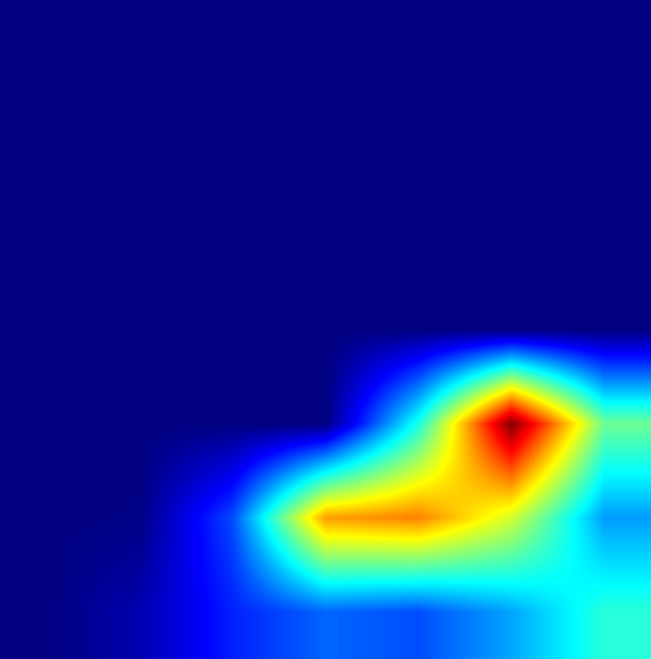

In [3]:
#  show cam image
cv2_imshow(cam3)

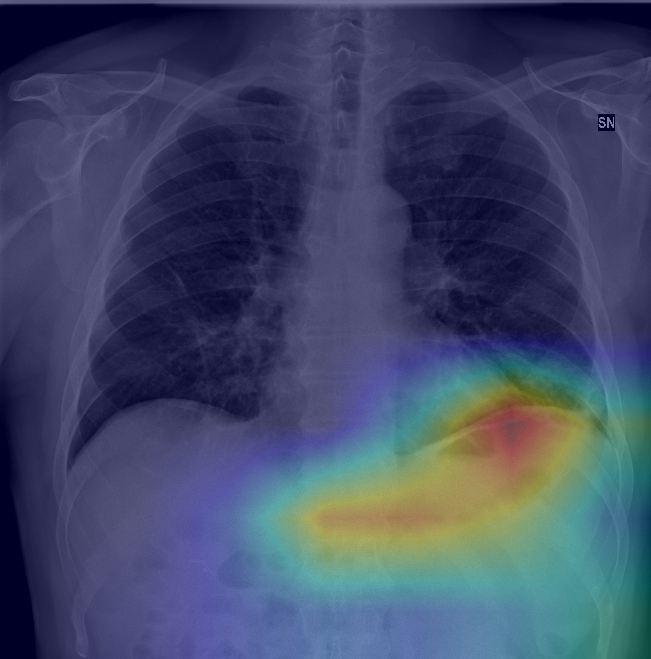

In [23]:

cv2_imshow(new_im)

In [24]:
new_im

array([[[130.4,  92. ,  92. ],
        [129.9,  91.5,  91.5],
        [129.9,  91.5,  91.5],
        ...,
        [122.9,  84.5,  84.5],
        [122.9,  84.5,  84.5],
        [122.9,  84.5,  84.5]],

       [[131.9,  93.5,  93.5],
        [130.4,  92. ,  92. ],
        [128.9,  90.5,  90.5],
        ...,
        [122.9,  84.5,  84.5],
        [122.9,  84.5,  84.5],
        [122.9,  84.5,  84.5]],

       [[133.4,  95. ,  95. ],
        [131.4,  93. ,  93. ],
        [129.9,  91.5,  91.5],
        ...,
        [ 91.9,  53.5,  53.5],
        [ 91.9,  53.5,  53.5],
        [ 91.9,  53.5,  53.5]],

       ...,

       [[ 38.9,   0.5,   0.5],
        [ 38.9,   0.5,   0.5],
        [ 38.9,   0.5,   0.5],
        ...,
        [ 65.9,  77. ,  11.9],
        [ 65.9,  77. ,  11.9],
        [ 65.9,  77. ,  11.9]],

       [[ 38.9,   0.5,   0.5],
        [ 38.9,   0.5,   0.5],
        [ 38.9,   0.5,   0.5],
        ...,
        [ 65.9,  77. ,  11.9],
        [ 65.9,  77. ,  11.9],
        [ 65.9,

In [25]:
new_im.dtype

dtype('float64')

In [26]:
showimg = new_im.astype('uint8')

In [27]:
showimg.dtype

dtype('uint8')

## show plot img

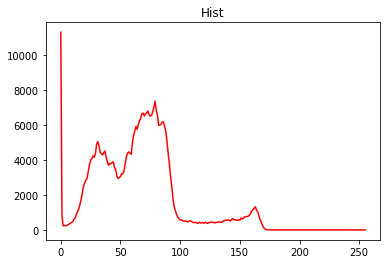

In [15]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from matplotlib import pyplot as plt
  
# reading the input image
# img = cv2.imread('./assets/ex-covid.jpeg')

hist = cv2.calcHist([showimg],[0],None,[256],[0,256])
hist = hist.reshape(256)
hist2 = cv2.calcHist([showimg],[2],None,[256],[0,256])
hist2 = hist2.reshape(256)
hist3 = cv2.calcHist([showimg],[1],None,[256],[0,256])
hist3 = hist3.reshape(256)
# plt.plot(hist, color='b')
plt.plot(hist2, color='r')
# plt.plot(hist3, color='g')
plt.title('Hist')
plt.show()

## make it as a method

In [25]:
def main_grad(args_impath):
  # # add more photo
  # args_impath = "./covid-chestxray-dataset-master/images/000001-1.jpg"
  image_tensor = graph.get_tensor_by_name(args_in_tensorname)
  gradCam = GradCAM(graph=graph, classes = [0,1,2], outLayer=args_out_tensorname, targetLayer=final_conv_name)

  grads = gradCam.compute_grads()

  x, origin_im = process_image_file(args_impath, args_top_percent, args_input_size)
  img_arr = np.asanyarray(x)
  size_upsample = (origin_im.shape[1],origin_im.shape[0]) # (w, h)

  x = x.astype('float32') / 255.0
  output, grads_val = sess.run([gradCam.target, grads[mapping[args_pred_class]]], feed_dict={image_tensor: np.expand_dims(x, axis=0)})

  cam3 = generate_cam(output[0],grads_val[0],size_upsample)

  # Overlay cam on image
  cam3 = np.uint8(255*cam3)
  cam3 = cv2.applyColorMap(cam3, cv2.COLORMAP_JET)
  
  im_name = args_impath.split("/")[-1]
  ext = im_name.split(".")[-1]


  # show!!!!
  cam3_resize = cv.resize(cam3, (224, 224))
  
  cv2.imwrite("cam-1.png", cam3_resize)
  cv2_imshow(cam3_resize)

  new_im = cam3*0.3 + origin_im*0.5


  # Save the GradCAM
  cv2.imwrite(os.path.join(args_outdir, "{}_{}png".format(args_pred_class, im_name.rstrip(ext))), new_im)

  # print("GradCAM image is save in ", args_outdir)

  # show images:
  # imagepath = "assets/ex-covid.jpeg"
  img_m = cv.imread(args_impath)
  img_m = cv.resize(img_m, (224, 224))

  # display(Image(imagepath))
  cv2_imshow(img_m)  # oringinal
  new_im_2 = cv.resize(new_im, (224, 224))
  cv2_imshow(new_im_2)  # grad-cam

# Recognize lung independently

 ## prepare choose 10 imgs
 - 30 imgs


In [6]:
img_num_set = [29, 51, 73, 75, 100, 125, 178, 199, 251, 257]
'''
 img_num_set = [29, 51, 73, 75, 100, 125, 178, 199, 244, 257,
                288, 297, 325, 361, 369, 478, 498, 509, 514, 642,
              #  659, 720, 757, 763, 823, 836, 877, 890, 913, 942]
'''
# 53: radiopaedia_org_covid-19-pneumonia-7_85703_0-dcm.nii.gz unknown
# 243: radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm.nii.gz unknown

'\n img_num_set = [29, 51, 73, 75, 100, 125, 178, 199, 244, 257,\n                288, 297, 325, 361, 369, 478, 498, 509, 514, 642,\n              #  659, 720, 757, 763, 823, 836, 877, 890, 913, 942]\n'

In [7]:
# import metedata

metadata_covid_chest = './covid-chestxray-dataset-master/metadata.csv'
pd_reader = pd.read_csv(metadata_covid_chest)
print(pd_reader)

    patientid  offset sex   age                   finding RT_PCR_positive  \
0           2     0.0   M  65.0  Pneumonia/Viral/COVID-19               Y   
1           2     3.0   M  65.0  Pneumonia/Viral/COVID-19               Y   
2           2     5.0   M  65.0  Pneumonia/Viral/COVID-19               Y   
3           2     6.0   M  65.0  Pneumonia/Viral/COVID-19               Y   
4           4     0.0   F  52.0  Pneumonia/Viral/COVID-19               Y   
..        ...     ...  ..   ...                       ...             ...   
945       479     0.0   F  40.0                 Pneumonia             NaN   
946       479    70.0   F  40.0                 Pneumonia             NaN   
947       480     NaN   M  26.0                 Pneumonia             NaN   
948       481     NaN   M  50.0                 Pneumonia             NaN   
949       481     NaN   M  50.0                 Pneumonia             NaN   

    survival intubated intubation_present went_icu  ...              date  

In [8]:
image_name_all =pd_reader['filename']
PCR_result_all = pd_reader['RT_PCR_positive']

In [9]:
pd_reader.index.rename('index', inplace=True)
# lines = pd_reader2['index']
pd_reader

,patientid,offset,sex,age,finding,RT_PCR_positive,survival,intubated,intubation_present,went_icu,...,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 29
index,,,,,,,,,,,,,,,,,,,,,
0,2,0.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
2,2,5.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
3,2,6.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
4,4,0.0,F,52.0,Pneumonia/Viral/COVID-19,Y,NaN,N,N,N,...,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
945,479,0.0,F,40.0,Pneumonia,NaN,NaN,NaN,NaN,NaN,...,NaN,United Kingdom,images,072ecaf8c60a81980abb57150a8016_jumbo-9.jpeg,NaN,https://radiopaedia.org/cases/multifocal-round...,CC BY-NC-SA,Asthmatic. Shortness of breath and wheeze. Rou...,"Case courtesy of Dr Ian Bickle, Radiopaedia.or...",NaN
946,479,70.0,F,40.0,Pneumonia,NaN,NaN,NaN,NaN,NaN,...,NaN,United Kingdom,images,ff33c406392b968d483174c97eb857_jumbo-9.jpeg,NaN,https://radiopaedia.org/cases/multifocal-round...,CC BY-NC-SA,Asthmatic. Shortness of breath and wheeze. The...,"Case courtesy of Dr Ian Bickle, Radiopaedia.or...",NaN
947,480,NaN,M,26.0,Pneumonia,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,images,000001-266.jpg,NaN,https://www.eurorad.org/case/947,CC BY-NC-SA 4.0,fire-eater accidentally ingested a paraffin mi...,NaN,NaN


## grad cam result

Num#: 29
ryct.2020200034.fig2.jpeg
Current img: ryct.2020200034.fig2.jpeg


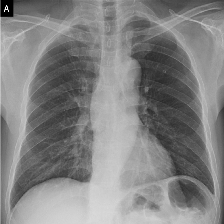

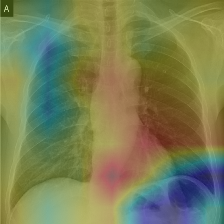

0 Y
Num#: 51
covid-19-pneumonia-7-PA.jpg
Current img: covid-19-pneumonia-7-PA.jpg


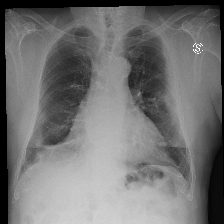

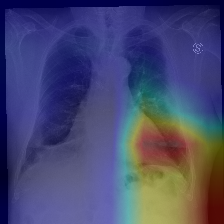

1 Y
Num#: 73
44C8E3D6-20DA-42E9-B33B-96FA6D6DE12F.jpeg
Current img: 44C8E3D6-20DA-42E9-B33B-96FA6D6DE12F.jpeg


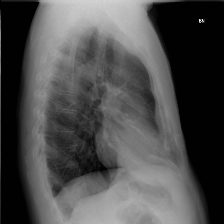

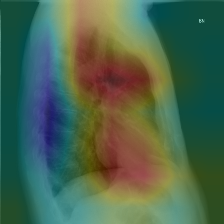

2 Y
Num#: 75
2C10A413-AABE-4807-8CCE-6A2025594067.jpeg
Current img: 2C10A413-AABE-4807-8CCE-6A2025594067.jpeg


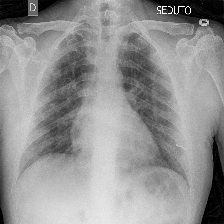

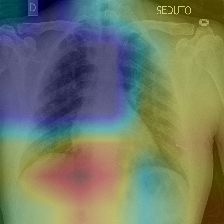

3 Y
Num#: 100
B59DD164-51D5-40DF-A926-6A42DD52EBE8.jpeg
Current img: B59DD164-51D5-40DF-A926-6A42DD52EBE8.jpeg


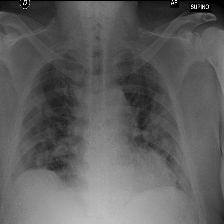

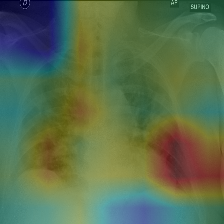

4 Y
Num#: 125
kjr-21-e24-g003-l-a.jpg
Current img: kjr-21-e24-g003-l-a.jpg


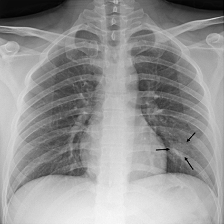

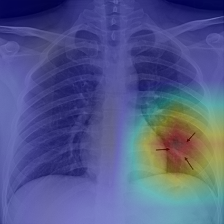

5 Y
Num#: 178
6b44464d-73a7-4cf3-bbb6-ffe7168300e3.annot.original.jpeg
Current img: 6b44464d-73a7-4cf3-bbb6-ffe7168300e3.annot.original.jpeg


<ipython-input-9-52d49951f23f>:148: RuntimeWarning: invalid value encountered in true_divide
  cam = cam/np.max(cam)


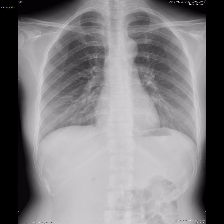

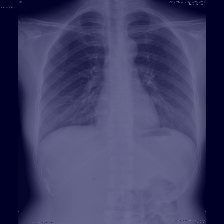

6 Unclear
Num#: 199
pneumocystis-carinii-pneumonia-1-PA.jpg
Current img: pneumocystis-carinii-pneumonia-1-PA.jpg


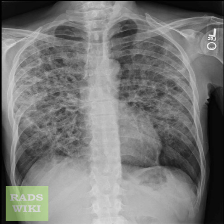

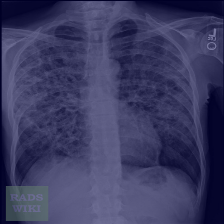

7 nan
Num#: 251
covid-19-caso-70-2-APS.jpg
Current img: covid-19-caso-70-2-APS.jpg


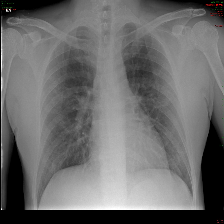

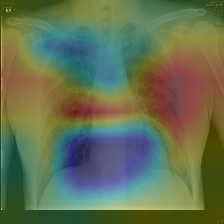

8 Y
Num#: 257
post-intubuation-pneumomediastium-and-pneumothorax-background-covid-19-pneumonia-day7.jpg
Current img: post-intubuation-pneumomediastium-and-pneumothorax-background-covid-19-pneumonia-day7.jpg


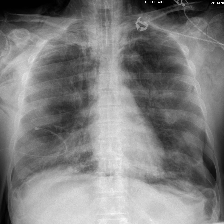

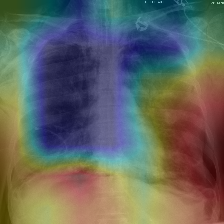

9 Y


In [24]:
# example 10
for i in range(10):
  num = img_num_set[i]
  print("Num#:", num)
  print(image_name_all[num])
  temp_name = pd_reader['filename'][num]
  print("Current img:", temp_name)
  main_grad('./covid-chestxray-dataset-master/images/' + temp_name)
  # main_grad('./covid-chestxray-dataset-master/images/' + image_name_all[num])
  print(i, PCR_result_all[num])

## show lung

Num#: 29
ryct.2020200034.fig2.jpeg
Current img: ryct.2020200034.fig2.jpeg


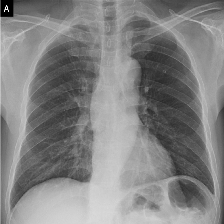

0 Y
Num#: 51
covid-19-pneumonia-7-PA.jpg
Current img: covid-19-pneumonia-7-PA.jpg


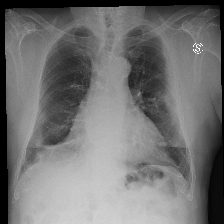

1 Y
Num#: 73
44C8E3D6-20DA-42E9-B33B-96FA6D6DE12F.jpeg
Current img: 44C8E3D6-20DA-42E9-B33B-96FA6D6DE12F.jpeg


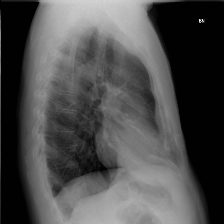

2 Y
Num#: 75
2C10A413-AABE-4807-8CCE-6A2025594067.jpeg
Current img: 2C10A413-AABE-4807-8CCE-6A2025594067.jpeg


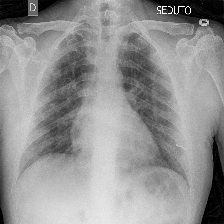

3 Y
Num#: 100
B59DD164-51D5-40DF-A926-6A42DD52EBE8.jpeg
Current img: B59DD164-51D5-40DF-A926-6A42DD52EBE8.jpeg


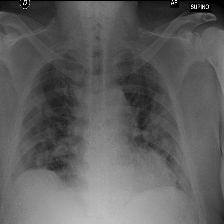

4 Y
Num#: 125
kjr-21-e24-g003-l-a.jpg
Current img: kjr-21-e24-g003-l-a.jpg


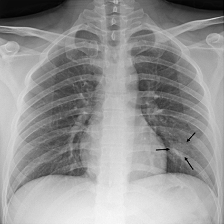

5 Y
Num#: 178
6b44464d-73a7-4cf3-bbb6-ffe7168300e3.annot.original.jpeg
Current img: 6b44464d-73a7-4cf3-bbb6-ffe7168300e3.annot.original.jpeg


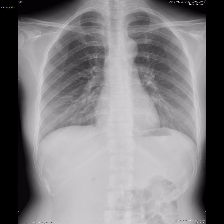

6 Unclear
Num#: 199
pneumocystis-carinii-pneumonia-1-PA.jpg
Current img: pneumocystis-carinii-pneumonia-1-PA.jpg


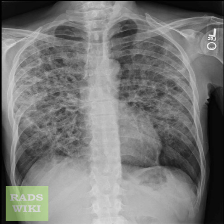

7 nan
Num#: 251
covid-19-caso-70-2-APS.jpg
Current img: covid-19-caso-70-2-APS.jpg


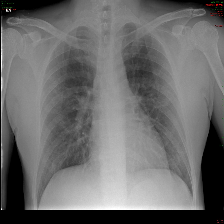

8 Y
Num#: 257
post-intubuation-pneumomediastium-and-pneumothorax-background-covid-19-pneumonia-day7.jpg
Current img: post-intubuation-pneumomediastium-and-pneumothorax-background-covid-19-pneumonia-day7.jpg


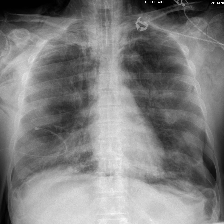

9 Y


In [7]:
# example 10
for i in range(10):
  num = img_num_set[i]
  print("Num#:", num)
  print(image_name_all[num])
  temp_name = pd_reader['filename'][num]
  print("Current img:", temp_name)
  img_m = cv.imread('./covid-chestxray-dataset-master/images/' + temp_name)
  img_m = cv.resize(img_m, (224, 224))
  cv2_imshow(img_m)
  # main_grad('./covid-chestxray-dataset-master/images/' + temp_name)
  print(i, PCR_result_all[num])

### 1

Num#: 29
ryct.2020200034.fig2.jpeg
Current img: ryct.2020200034.fig2.jpeg


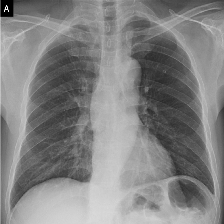

0 Y


In [21]:
num = img_num_set[0]
print("Num#:", num)
print(image_name_all[num])
temp_name = pd_reader['filename'][num]
print("Current img:", temp_name)
img_m = cv.imread('./covid-chestxray-dataset-master/images/' + temp_name)
img_m = cv.resize(img_m, (224, 224))
cv2_imshow(img_m)

# save original image for change
cv2.imwrite(temp_name, img_m)
# img_m.save(temp_name + ".jpg")

# main_grad('./covid-chestxray-dataset-master/images/' + temp_name)
print(0, PCR_result_all[num])

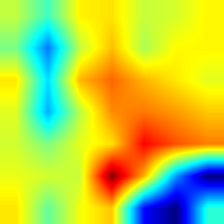

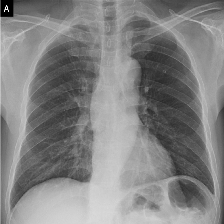

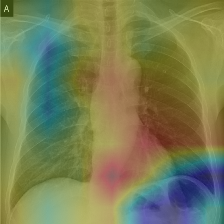

In [26]:
main_grad('./covid-chestxray-dataset-master/images/' + temp_name)

In [15]:
img_m.shape

(224, 224, 3)

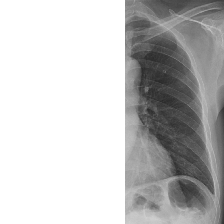

In [30]:
# import numpy  as  np
from PIL import Image
colorl =[255,255,255]

#依次遍历我们需要修改颜色的图片区域
for col in  range (0,125):
    for row in range (0,224):
        img_m[row,col]=colorl
new_img=Image.fromarray(img_m)
new_img.show()
new_img.save("example_with_white.jpg")


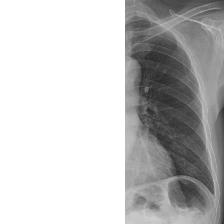

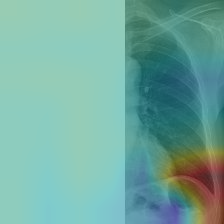

In [31]:
main_grad('example_with_white.jpg')

lung-ryct.2020200034.fig2.jpeg


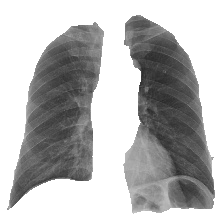

In [49]:
# show lung 1
print('lung-' + temp_name)
# img_lung= cv.imread('lung-' + temp_name)
img_lung= cv.imread('lung-ryct.2020200034.png')
img_lung = cv.resize(img_lung, (224, 224))
cv2_imshow(img_lung)

In [35]:
img_lung.shape

(224, 224, 3)

In [37]:
len(img_lung)

224

In [50]:
for i in range(len(img_lung)):
  for j in range(len(img_lung[0])):
    for k in range(len(img_lung[0][0])):
      if img_lung[i][j][k] == 255:
        pass
      else:
        img_lung[i][j][k] = 0
img_lung

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

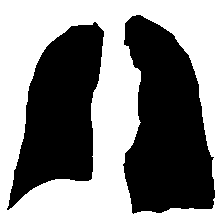

In [51]:
cv2_imshow(img_lung)

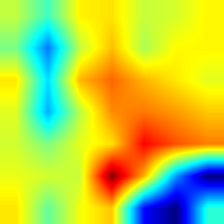

In [28]:
img_cam= cv.imread('cam-1.png')
cv2_imshow(img_cam)

In [ ]:
img_cam

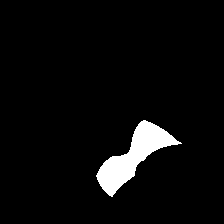

In [55]:
img = cv2.imread('cam-1.png')
# 在彩色图像的情况下，解码图像将以b g r顺序存储通道。
grid_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 从RGB色彩空间转换到HSV色彩空间
grid_HSV = cv2.cvtColor(grid_RGB, cv2.COLOR_RGB2HSV)

# H、S、V范围一：
lower1 = np.array([0,43,46])
upper1 = np.array([10,255,255])
mask1 = cv2.inRange(grid_HSV, lower1, upper1)       # mask1 为二值图像
res1 = cv2.bitwise_and(grid_RGB, grid_RGB, mask=mask1)

# H、S、V范围二：
lower2 = np.array([156,43,46])
upper2 = np.array([180,255,255])
mask2 = cv2.inRange(grid_HSV, lower2, upper2)
res2 = cv2.bitwise_and(grid_RGB,grid_RGB, mask=mask2)

# 将两个二值图像结果 相加
mask3 = mask1 + mask2

# 结果显示
cv2_imshow(mask3)  #"mask3", 
# cv2_imshow(img)  #"img",
# cv2_imshow(mask1)  #"Mask1",
# cv2_imshow(res1)  #"res1",
# cv2_imshow(mask2)  #"Mask2",
# cv2_imshow(res2)   #"res2",

# # imshow()函数传入的变量也要为b g r通道顺序
# cv2_imshow(grid_RGB[:,:,::-1])   # "grid_RGB",       # cv2.waitKey(0)
# cv2.destroyAllWindows()

In [58]:
mask3.shape

(224, 224)

In [59]:

for j in range(len(mask3)):
  for k in range(len(mask3[0])):
    if mask3[j][k] == 255:
      mask3[j][k] = 0
    else:
      mask3[j][k] = 255
mask3

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

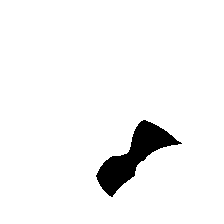

In [60]:
cv2_imshow(mask3)

### compare

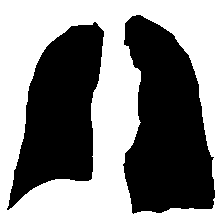

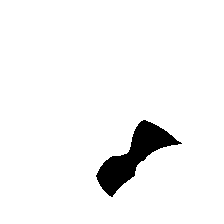

In [61]:
cv2_imshow(img_lung)
cv2_imshow(mask3)

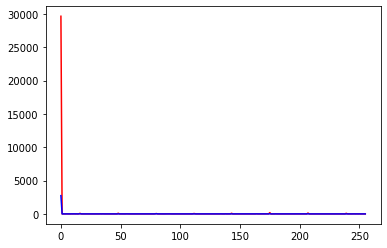

degree:  [0.83055645]


In [63]:
# 利用python实现实现图像识别:比较两图像直方图相似性
# 核心：计算直方图重合度
 
import cv2
import numpy as np
from matplotlib import pyplot as plt
 
 
# 最简单的以灰度直方图作为相似比较的实现
def classify_gray_hist(image1, image2, size=(256, 256)):
    # 先计算直方图
    # 几个参数必须用方括号括起来
    # 这里直接用灰度图计算直方图，所以是使用第一个通道，
    # 也可以进行通道分离后，得到多个通道的直方图
    image1 = cv2.resize(image1, size)
    image2 = cv2.resize(image2, size)
    hist1 = cv2.calcHist([image1], [0], None, [256], [0.0, 255.0])
    hist2 = cv2.calcHist([image2], [0], None, [256], [0.0, 255.0])
	
    # 可以比较下直方图
    plt.plot(range(256), hist1, 'r')
    plt.plot(range(256), hist2, 'b')
    plt.show()
	
    # 计算直方图的重合度
    degree = 0
    for i in range(len(hist1)):
        if hist1[i] != hist2[i]:
            degree = degree + (1 - abs(hist1[i] - hist2[i]) / max(hist1[i], hist2[i]))
        else:
            degree = degree + 1
    degree = degree / len(hist1)
    return degree
 
if __name__ == '__main__':
    # 读取图片并显示
    # img1 = cv2.imread('B.jpg')
    # cv2.imshow('img1', img1)
    # img2 = cv2.imread('A.jpg')
    # cv2.imshow('img2', img2)
	
    degree = classify_gray_hist(img_lung, mask3)
    print("degree: ", degree)
    cv2.waitKey(0)

### plot

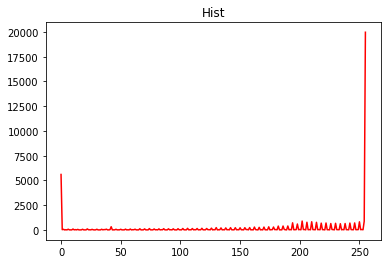

In [30]:
hist = cv2.calcHist([img_cam],[0],None,[256],[0,256])
hist = hist.reshape(256)
hist2 = cv2.calcHist([img_cam],[2],None,[256],[0,256])
hist2 = hist2.reshape(256)
hist3 = cv2.calcHist([img_cam],[1],None,[256],[0,256])
hist3 = hist3.reshape(256)
# plt.plot(hist, color='b')
plt.plot(hist2, color='r')
# plt.plot(hist3, color='g')
plt.title('Hist')
plt.show()

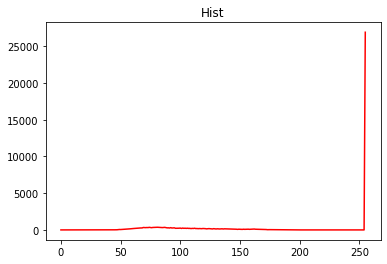

In [33]:
hist = cv2.calcHist([img_lung],[0],None,[256],[0,256])
hist = hist.reshape(256)
hist2 = cv2.calcHist([img_lung],[2],None,[256],[0,256])
hist2 = hist2.reshape(256)
hist3 = cv2.calcHist([img_lung],[1],None,[256],[0,256])
hist3 = hist3.reshape(256)
# plt.plot(hist, color='b')
plt.plot(hist2, color='r')
# plt.plot(hist3, color='g')
plt.title('Hist')
plt.show()

In [ ]:
# add a threshold